# Проект 7 - Приоритезация гипотез и A/B тесты

## Введение

**Описание проекта**

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

**Описание данных**

Таблица `hypothesis.csv`.

1. `Hypothesis` — краткое описание гипотезы
2. `Reach` — охват пользователей по 10-балльной шкале
3. `Impact` — влияние на пользователей по 10-балльной шкале
4. `Confidence` — уверенность в гипотезе по 10-балльной шкале
5. `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы

Таблица `orders.csv`.

1. `transactionId` — идентификатор заказа
2. `visitorId` — идентификатор пользователя, совершившего заказ
3. `date` — дата, когда был совершён заказ
4. `revenue` — выручка заказа
5. `group` — группа A/B-теста, в которую попал заказ

Таблица `visitors.csv`.

1. `date` — дата
2. `group` — группа A/B-теста
3. `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Предобработка данных

Для начала проверим какие данные нам достались. Нас интересуют:

1. Названия колонок.
2. Артефакты в данных.
3. Типы данных.

Пойдем по порядку.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from datetime import datetime, timedelta
from IPython.display import display
plt.style.use('default')

# Save raw datasets in case we need them
try:
    raw_visitors = pd.read_csv('visitors.csv')
    raw_orders = pd.read_csv('orders.csv')
    raw_hypothesis = pd.read_csv('hypothesis.csv')
except:
    raw_visitors = pd.read_csv('/datasets/visitors.csv')
    raw_orders = pd.read_csv('/datasets/orders.csv')
    raw_hypothesis = pd.read_csv('/datasets/hypothesis.csv')

# Constants, which we will need later
FIG_WIDTH = 10
FIG_HEIGHT = 5


In [3]:
# Let's have a look what is inside
for data_frame in [raw_visitors, raw_orders, raw_hypothesis]:
    display(data_frame.head(3))
    data_frame.info()
    print(50 * '-')


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
--------------------------------------------------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
--------------------------------------------------


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
--------------------------------------------------


Очень красивые таблицы. Причешем их немного.

In [4]:
# Datasets, which we will clean up
df_visitors, df_orders, df_hypothesis = (
    raw_visitors.copy(), raw_orders.copy(), raw_hypothesis.copy()
)

df_visitors = df_visitors.sort_values(by='date')
df_orders = df_orders.sort_values(by='date')

# Snake case for column names
for data_frame in [df_visitors, df_orders, df_hypothesis]:
    data_frame.columns = data_frame.columns.str.lower()

# Rename a couple of columns
df_orders = (
    df_orders
    .rename(
        columns={
            'transactionid': 'transaction_id',
            'visitorid': 'visitor_id'
        }
    )
)

# Set data types
df_visitors = (
    df_visitors
    .astype({
        'date': 'datetime64[D]',
        'group': 'object',
        'visitors': 'int64'
    })
)

df_orders = (
    df_orders
    .astype({
        'transaction_id': 'int64',
        'visitor_id': 'int64',
        'date': 'datetime64[D]',
        'revenue': 'int64',
        'group': 'object'
    })
)

df_hypothesis = (
    df_hypothesis
    .astype({
        'hypothesis': 'object',
        'reach': 'int64',
        'impact': 'int64',
        'confidence': 'int64',
        'efforts': 'int64',
    })
)


Проверим данные на артефакты.

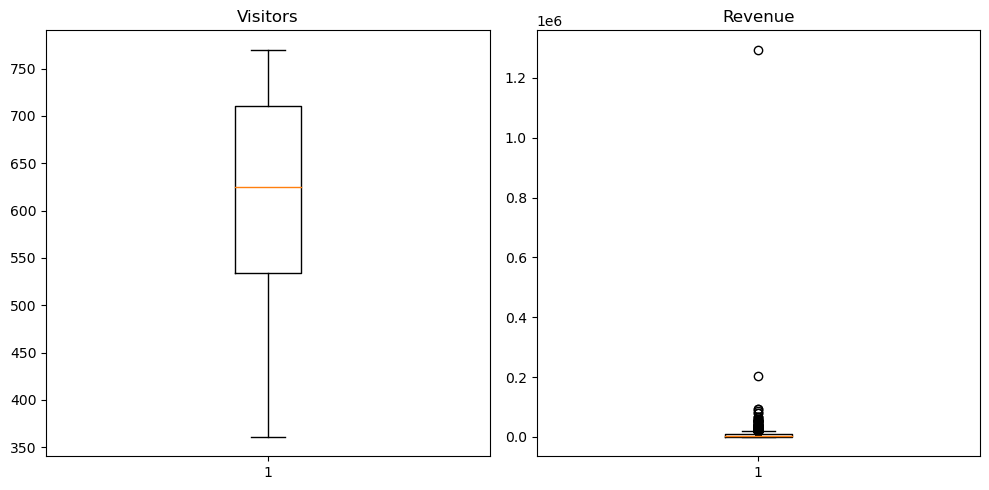

In [5]:
# Boxplots first
def fun_get_boxplots_for_columns(columns: list,
                                 titles: list,
                                 num_rows: int,
                                 num_columns: int):
    """
    This function creates a num_rows x num_columns box subplots for a list of columns out of the dataset.

    Args:
        columns (List): list of columns to plot from a DataFrame.

        titles (List): list of titles for subplots.

        num_rows (int): number of rows in subplots.

        num_columns (int): number of columns in subplots.
    """
    # Create subplots
    fig, axs = plt.subplots(
        num_rows, num_columns,
        figsize=(FIG_WIDTH, FIG_HEIGHT)
    )

    # Popuplate subplots
    for i, ax in enumerate(axs.flat):
        ax.boxplot(columns[i].dropna())
        ax.set_title(titles[i])

    plt.tight_layout()


fun_get_boxplots_for_columns(
    [df_visitors.visitors, df_orders.revenue],
    ['Visitors', 'Revenue'],
    1, 2
)


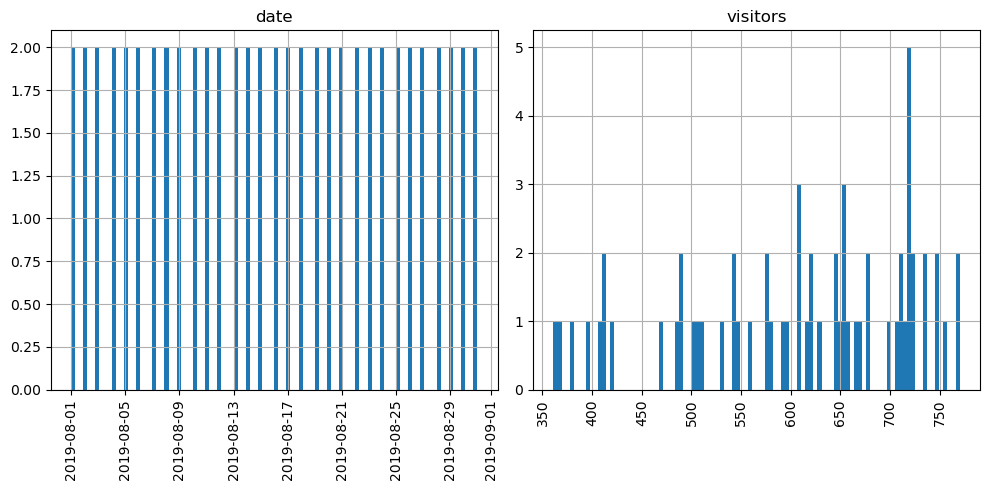

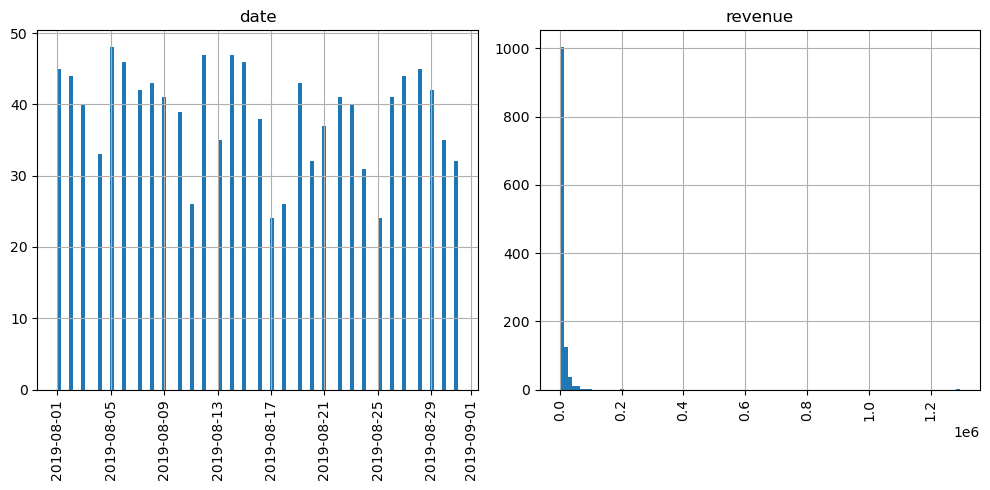

In [6]:
# Histograms
for data_frame in [
    df_visitors[['date', 'visitors']], 
    df_orders[['date', 'revenue']]
    ]:
    
    data_frame.hist(
        bins=100,
        figsize=(FIG_WIDTH, FIG_HEIGHT),
        xrot=90
    )
    
    plt.tight_layout()


У нас явно есть выбросы в данных `revenue`. Дальше по заданию нас просят посчитать перцентили, поэтому мы разберемся с ними позже.

## Приоритизация гипотез

Посмотрим, какие гипотезы у нас есть, какие из них интереснее.

In [7]:
# ICE and RICE prioritization
df_hypothesis['ice'] = df_hypothesis.impact * df_hypothesis.confidence / df_hypothesis.efforts
df_hypothesis['rice'] = df_hypothesis.reach * df_hypothesis.impact * df_hypothesis.confidence / df_hypothesis.efforts
df_hypothesis = df_hypothesis.sort_values(by=['ice', 'rice'], ascending=False)

# Show me the whole dataframe
(df_hypothesis
 .style
 .background_gradient()
 .format({
     'ice': '{:.1f}',
     'rice': '{:.1f}'
 })
)

,hypothesis,reach,impact,confidence,efforts,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


Резльутаты получились интересные:

1. По ICE самые привлекательные гипотезе - #8 и #0. Обе находятся высоко в списке, потому что `impact` и `confidence` самые высокие, при `effort` в районе 5.

2. По RICE самые привлекательные гипотезы #7 и #2. Они так высокоо, потому что имеют самый большой `reach` по сравнению с остальными гипотезами. Это же объясняет разницу между ICE и RICE.


## A/B тестирование

### Создаем таблицу-резюме

Чтобы провести анализ, сначала соберем данные в единую таблицу `pvt_summary`. Она покажет нам как в зависимости от группы пользователей менялись метрики во времени. 

In [8]:
# Create a function for excavations
def fun_get_group_summary(visitors: pd.DataFrame, orders: pd.DataFrame) -> pd.DataFrame:
    """
    This function creates a summary table of visitors and orders placed per user group, per date.

    Args:
        visitors (pd.DataFrame): a dataframe with visit date, user group and number of visitors.
        orders (pd.DataFrame): a dataframe with transaction id, visitor id, order date, order value and user group.
        
    Returns:
        summary (pd.DataFrame): a summary dataframe with per group metrics: no. of visitors, revenue earned,
        no. of orders placed, average order size and conversion.
    """
    summary = (
        pd.merge(
            left=(
                pd.pivot_table(
                    data=visitors,
                    index='date',
                    columns='group',
                    values='visitors',
                    aggfunc='sum'
                )
            ),
            right=(
                pd.pivot_table(
                    data=orders,
                    index='date',
                    columns='group',
                    values=['transaction_id', 'revenue'],
                    aggfunc={
                        'transaction_id': 'nunique',
                        'revenue': 'sum'
                    }
                )
                .droplevel(1, axis=1)
            ),
            on='date',
            how='left'
        )
    )

    summary.columns = [
        'visitors_a',
        'visitors_b',
        'revenue_a',
        'revenue_b',
        'order_count_a',
        'order_count_b'
    ]

    # Get cumulative columns for each metric and group
    for column in summary.columns:
        summary[column + '_cum'] = summary[column].cumsum()
        
    # Additional order metrics per group
    summary['avg_order_a'] = summary.revenue_a_cum / summary.order_count_a_cum
    summary['avg_order_b'] = summary.revenue_b_cum / summary.order_count_b_cum
    summary['avg_order_b_to_a'] = (summary.avg_order_b / summary.avg_order_a - 1) * 100

    # Additional conversion metrics per group
    summary['conversion_a_cum'] = summary.order_count_a_cum / summary.visitors_a_cum * 100
    summary['conversion_b_cum'] = summary.order_count_b_cum / summary.visitors_b_cum * 100
    summary['conversion_b_to_a'] = (summary.conversion_b_cum / summary.conversion_a_cum - 1) * 100
    
    return summary

pvt_summary_all_visitors = fun_get_group_summary(df_visitors, df_orders)


### Анализруем результаты - выручка, средний чек и конверсия

Теперь посмотрим, что получилось

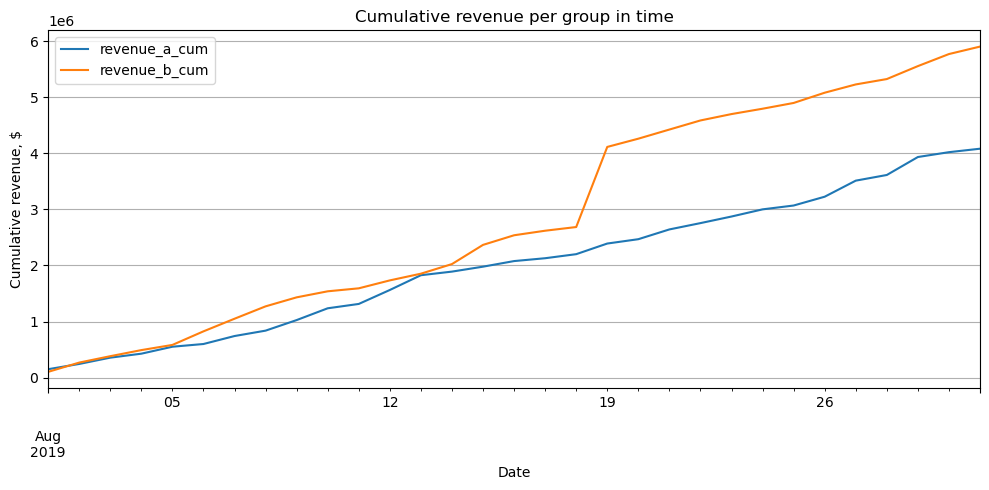

In [9]:
pvt_summary_all_visitors.plot(
    kind='line',
    y=['revenue_a_cum', 'revenue_b_cum'],
    figsize=(FIG_WIDTH, FIG_HEIGHT),
    grid=True,
    title='Cumulative revenue per group in time',
    ylabel='Cumulative revenue, $',
    xlabel='Date'
);
plt.tight_layout()


Похоже, первое интересное наблюдение. Кумулятивная выручка в группе Б немного увеличивается 5 августа, а потом значительно прыгает вверх в районе 18 августа. Учитывая, что потом кривые идут параллельно, скорей всего это просто выброс.

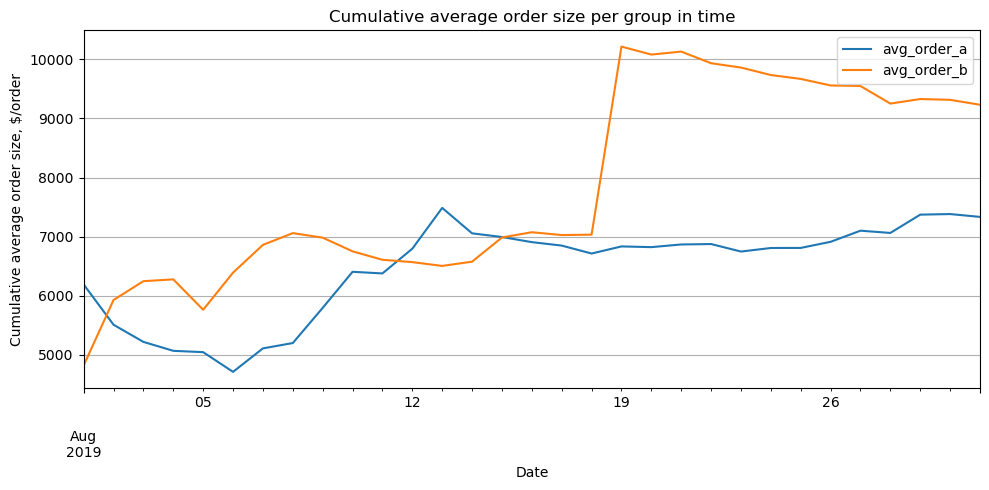

In [10]:
pvt_summary_all_visitors.plot(
    kind='line',
    y=['avg_order_a', 'avg_order_b'],
    figsize=(FIG_WIDTH, FIG_HEIGHT),
    grid=True,
    title='Cumulative average order size per group in time',
    ylabel='Cumulative average order size, $/order',
    xlabel='Date'
);
plt.tight_layout()

То же самое видим на графике средних чеков. Вероятно, увеличение связано с единоразовым выбросом в выручке с одного заказа.

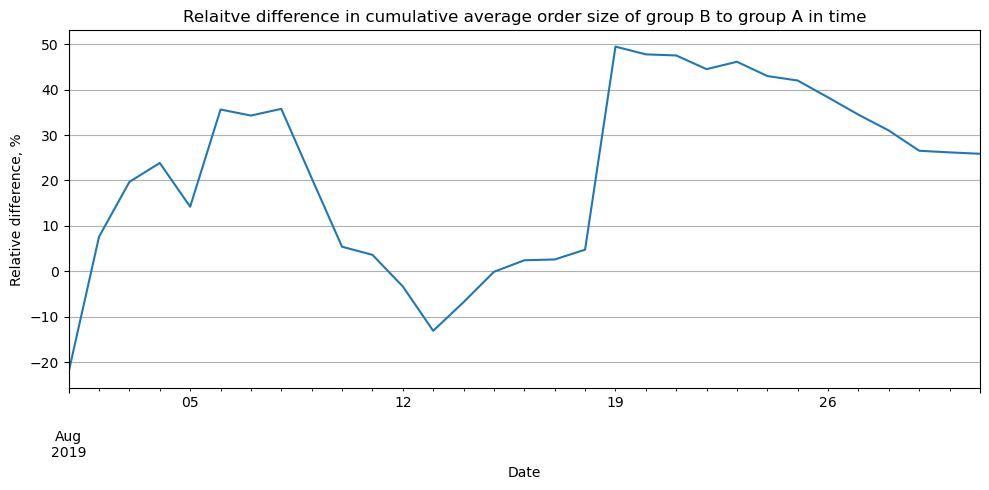

In [11]:
pvt_summary_all_visitors.plot(
    kind='line',
    y='avg_order_b_to_a',
    figsize=(FIG_WIDTH, FIG_HEIGHT),
    grid=True,
    legend=False,
    title='Relaitve difference in cumulative average order size of group B to group A in time',
    ylabel='Relative difference, %',
    xlabel='Date'
);
plt.tight_layout()

Относительная разница в среденем чеке между группами сильно колеблется в начале - это просто последствия размера выборки (помним про ошибку подсматривания). Дальше разница между средними чеками достигает 30%, но это опять из-за выброса. 

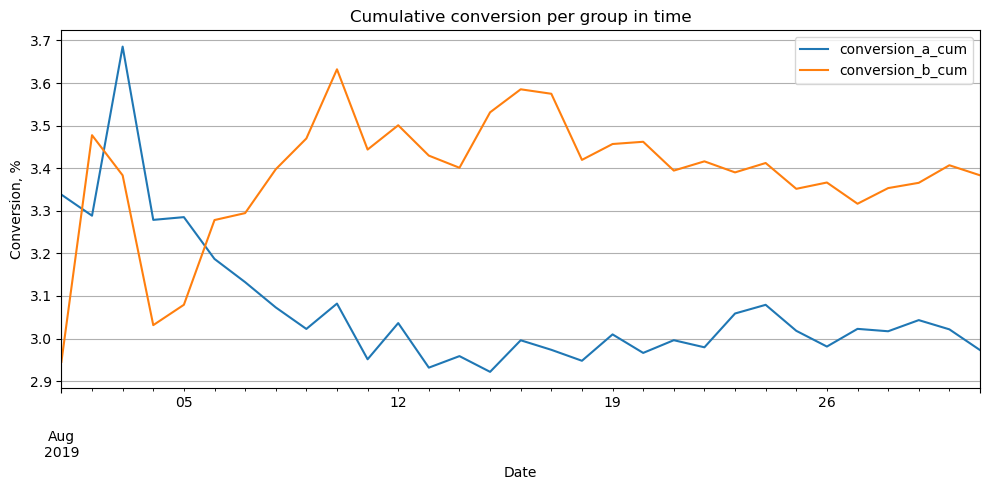

In [12]:
pvt_summary_all_visitors.plot(
    kind='line',
    y=['conversion_a_cum', 'conversion_b_cum'],
    figsize=(FIG_WIDTH, FIG_HEIGHT),
    grid=True,
    title='Cumulative conversion per group in time',
    ylabel='Conversion, %',
    xlabel='Date'
);
plt.tight_layout()

А вот это уже намного интереснее. Конверсия между двумя группами отличается - мы опять видим флуктуации в начале наблюдений, а потом группа Б достигает 3.4%, а группа А - 3.0%.

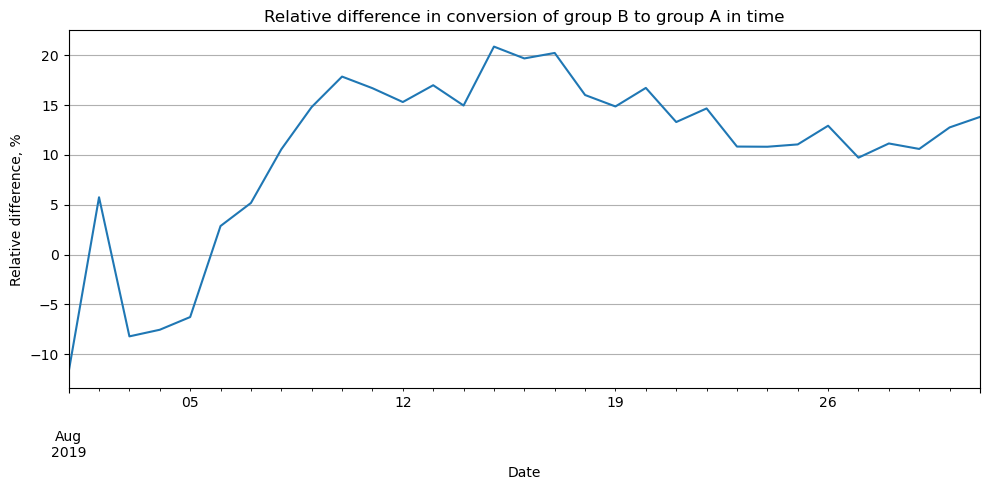

In [13]:
pvt_summary_all_visitors.plot(
    kind='line',
    y='conversion_b_to_a',
    figsize=(FIG_WIDTH, FIG_HEIGHT),
    grid=True,
    legend=False,
    title='Relative difference in conversion of group B to group A in time',
    ylabel='Relative difference, %',
    xlabel='Date'
);
plt.tight_layout()

То же самое видим на графике относительной разницы конверсий: она достигает 20% в середине августа и остается на уровне 10-15% дальше.

### Анализируем результаты - находим выбросы

Мы уже предварительно касались этой темы - похоже, в данных есть несколько странных значений. Посмотрим, как они выглядят на графиках.

90, 95 and 99 percentile of order size per user: [1. 2. 4.]


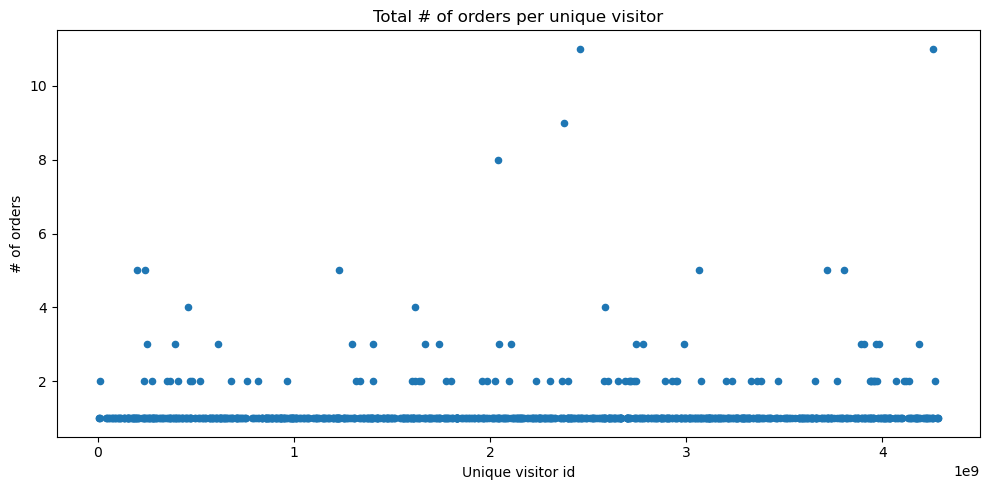

In [39]:
pvt_orders_per_all_visitors = (
    pd.pivot_table(
        data=df_orders,
        index='visitor_id',
        values='transaction_id',
        aggfunc='count'
        )
    .sort_values(by='transaction_id', ascending=False)
    .reset_index()
)
pvt_orders_per_all_visitors.columns = ['visitor_id', 'order_count']
pvt_orders_per_all_visitors.index.name = 'index'

pvt_orders_per_all_visitors.plot(
    kind='scatter',
    x='visitor_id',
    y='order_count',
    figsize=(FIG_WIDTH, FIG_HEIGHT),
    title='Total # of orders per unique visitor',
    ylabel='# of orders',
    xlabel='Unique visitor id'
);
plt.tight_layout()

print(
    '90, 95 and 99 percentile of order size per user:',
    np.percentile(pvt_orders_per_all_visitors.order_count, [90, 95, 99])
)

Вот первые виноватые - 99% клиентов делают меньше 4 заказов, но есть некоторые герои, которые делают 8 или даже 12 заказов! Дальше нам придется их вырезать из датасета.

90, 95 and 99 percentile of revenue per user: [19260.  32899.5 67750. ]


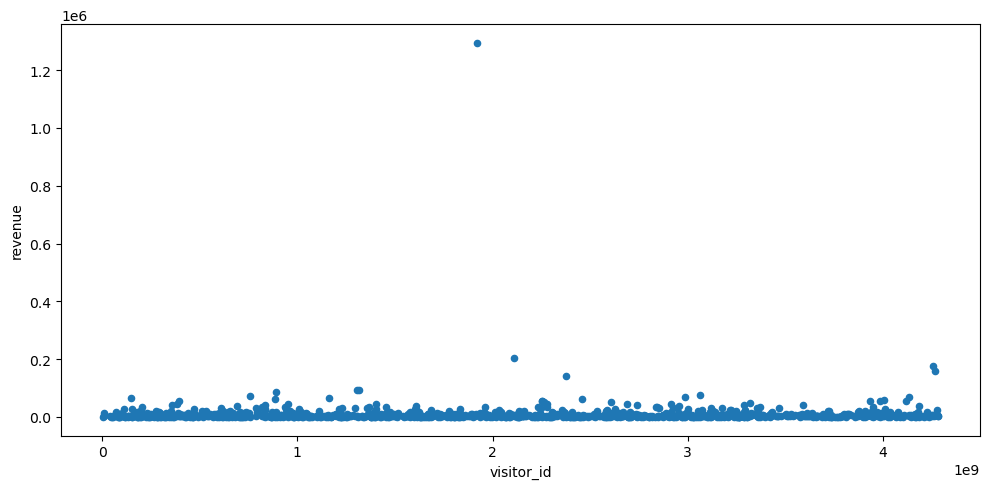

In [15]:
pvt_revenue_per_all_visitors = (
    pd.pivot_table(
        data=df_orders,
        index='visitor_id',
        values='revenue',
        aggfunc='sum'
    )
    .sort_values(by='revenue', ascending=False)
    .reset_index()
)
pvt_revenue_per_all_visitors.index.name = 'index'

pvt_revenue_per_all_visitors.plot(
    kind='scatter',
    y='revenue',
    x='visitor_id',
    figsize=(FIG_WIDTH, FIG_HEIGHT),
    title='Total revenue per unique visitor',
    ylabel='Total revenue, $',
    xlabel='Unique visitor id'
);
plt.tight_layout()

print(
    '90, 95 and 99 percentile of revenue per user:',
    np.percentile(pvt_revenue_per_all_visitors.revenue, [90, 95, 99])
)

А вот и наш главный виновник - клиент, который сделал заказ на 1.2 млн. $, хотя 99% наших заказов находятся в пределах 68K. Этого виновника точно придется убрать, потому что он может сильно исказить финальные выводы.

Код ниже определит подозрительных клиентов: либо с количеством заказов более 4, либо с общей выручкой более 68К.

In [16]:
# Identify normal and abnormal visitors
visitors_abnormal = (
    pd.concat([
            pvt_orders_per_all_visitors[
                pvt_orders_per_all_visitors.order_size
                >= np.percentile(pvt_orders_per_all_visitors.order_size, 99)
                ]
            .visitor_id,
            pvt_revenue_per_all_visitors[
                pvt_revenue_per_all_visitors.revenue
                >= np.percentile(pvt_revenue_per_all_visitors.revenue, 99)
                ]
            .visitor_id
        ],
        axis=0
    )
    .drop_duplicates()
)

visitors_normal = (
    df_orders[~df_orders.visitor_id.isin(visitors_abnormal)]
    .visitor_id
)


### Статистическая значимость различий между группами по сырым данным

Посмотрим, насколько значима разница между группами без обрезанных данных. Сначала добавим нужные таблицы.

In [17]:
# Get summary of "cleaned" data
pvt_summary_normal_visitors = fun_get_group_summary(
    df_visitors,
    df_orders[df_orders.visitor_id.isin(visitors_normal)]
)

# Get average order per customer per group
pvt_avg_revenue_per_normal_visitors = (
    pd.pivot_table(
        data=df_orders[df_orders.visitor_id.isin(visitors_normal)],
        columns='group',
        index='visitor_id',
        values='revenue',
        aggfunc='mean',
        fill_value=0
    )
    .reset_index()
)

pvt_avg_revenue_per_normal_visitors.columns = ['visitor_id', 'avg_order_a', 'avg_order_b']
pvt_avg_revenue_per_normal_visitors.index.name = 'index'

pvt_avg_revenue_per_all_visitors = (
    pd.pivot_table(
        data=df_orders,
        columns='group',
        index='visitor_id',
        values='revenue',
        aggfunc='mean',
        fill_value=0
    )
    .reset_index()
)

pvt_avg_revenue_per_all_visitors.columns = ['visitor_id', 'avg_order_a', 'avg_order_b']
pvt_avg_revenue_per_all_visitors.index.name = 'index'


Теперь проверим статистическую значимость по критерию Манна-Уитни до отчистки данных.

In [41]:
# Null hypothesis - there is no a statistical difference if p-value more than 5%
# Alternative hypothesis - there is a statistical difference if p-value less than 5%

# Conversion
print(
    'p-value for conversion difference across all visitors for group A and B:',
    '{0:.3%}'.format(
        st.mannwhitneyu(
            pvt_summary_all_visitors.conversion_a_cum,
            pvt_summary_all_visitors.conversion_b_cum
        )[1]
    )
)
print(
    'Relative difference between group B to group A conversion:',
    '{0:.1%}'.format(
        pvt_summary_all_visitors.conversion_b_cum.mean()
        / pvt_summary_all_visitors.conversion_a_cum.mean()
        - 1
    )
)
print('-' * 50)

# Average revenue per visitor
print(
    'p-value for average revenue difference across all visitors for group A and B:',
    '{0:.3%}'.format(
        st.mannwhitneyu(
            pvt_avg_revenue_per_all_visitors.avg_order_a,
            pvt_avg_revenue_per_all_visitors.avg_order_b
        )[1]
    )
)
print(
    'Relative difference between group B to group A average order size:',
    '{0:.1%}'.format(
        pvt_avg_revenue_per_all_visitors.avg_order_b.mean()
        / pvt_avg_revenue_per_all_visitors.avg_order_a.mean()
        - 1
    )
)
print('-' * 50)


p-value for conversion difference across all visitors for group A and B: 0.000%
Relative difference between group B to group A conversion: 10.2%
--------------------------------------------------
p-value for average revenue difference across all visitors for group A and B: 0.106%
Relative difference between group B to group A average order size: 47.2%
--------------------------------------------------


И после отчистки данных.

In [44]:
# Conversion
print(
    'p-value for conversion difference across normal visitors for group A and B:',
    '{0:.3%}'.format(
        st.mannwhitneyu(
            pvt_summary_normal_visitors.conversion_a_cum,
            pvt_summary_normal_visitors.conversion_b_cum
        )[1]
    )
)
print(
    'Relative difference between group B to group A conversion:',
    '{0:.1%}'.format(
        pvt_summary_normal_visitors.conversion_b_cum.mean()
        / pvt_summary_normal_visitors.conversion_a_cum.mean()
        - 1
    )
)
print('-' * 50)

# Average revenue per visitor
print(
    'p-value for average revenue difference across normal visitors for group A and B:',
    '{0:.3%}'.format(
        st.mannwhitneyu(
            pvt_avg_revenue_per_normal_visitors.avg_order_a,
            pvt_avg_revenue_per_normal_visitors.avg_order_b
        )[1]
    )
)
print(
    'Relative difference between group B to group A average order size:',
    '{0:.1%}'.format(
        pvt_avg_revenue_per_normal_visitors.avg_order_b.mean()
        / pvt_avg_revenue_per_normal_visitors.avg_order_a.mean()
        - 1
    )
)
print('-' * 50)


p-value for conversion difference across normal visitors for group A and B: 0.000%
Relative difference between group B to group A conversion: 9.8%
--------------------------------------------------
p-value for average revenue difference across normal visitors for group A and B: 0.099%
Relative difference between group B to group A average order size: 12.8%
--------------------------------------------------


## Выводы

Получился интересный проект:

1. Первым делом, вы сделали резюме по группам из таблиц визитов и заказов. Это позволило нам посмотреть на основные метрики по группам во времени (количество визитов, выручка, средний чек, количество заказов и другие): куммулятивная выручка в группе Б сильно выросла в середине августа - это связано с одним клиентом, который потратил 1.2 млн. $; конверсия для группы Б находится на 10% выше коневерсии для группы А (около 3.4% против 3.0%).

2. Следующим шагом, мы определили подозрительных клиентов. Для этого использовали 99-процентили по количеству заказов (любые клиенты с 5 и более заказами) и по суммарной выручке (любые клиенты, которые потратили более 68K $). Виноватых мы изолировали в отдельный список. С помощью него, мы получили таблицы с отчищенными данными.

3. Последним этапом, мы посмотрели насколько значимы различия в конверсии и среднем чеке между группами по исходным и отчищенным данным. В обоих случаях, для обоих метрик p-values оказались сильно меньше 5%, что позволяет нам отвергнуть нулевую гипотезу (статистически занчимых различий нет) и принять альтернативную гипотезу (статистически значимые различия есть). При этом, разница между конверсиями так и осталась в районе 10% (10.2% по исходным данным против 9.8% по отчищенным данным), а разница между средними чеками сильно упала (с 47.2% по исходным данным до 12.8% по отчищенным данным).

4. На основе этих результатов, мы можем остановить тест: есть статистически значимая разница в конверсии и в среднем чеке. Метрики группы Б выше, чем метрики группы А.
